In [1]:
from datetime import timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from basic_models import AlmgrenChriss, ObizhaevaWang
from price_impact import curr_file

from TickDataAccessor import DA
import TickDataLibrary td

PLOT_FOLDER = curr_file/ 'thesis'/'plots'
plt.style.use('bmh')

## Basic Models

### Almgren Chriss

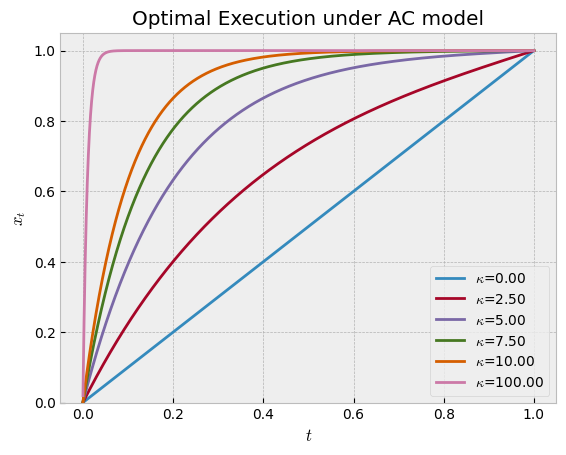

In [2]:
X_0 = 1
T = 1
kappa = 10

n = 5000
fig, ax = plt.subplots()

for kappa in np.linspace(0.0001, 10, 5):
    ac = AlmgrenChriss(X_0=X_0, kappa=kappa, T=T)
    times = np.linspace(0, ac.T, n)
    optimal_trades = ac.optimal_trades(n)
    ax.plot(times, optimal_trades.cumsum(), label=rf'$ \kappa $={ac.kappa:.2f}')

ac = AlmgrenChriss(X_0=X_0, kappa=100, T=T)
times = np.linspace(0, ac.T, n)
optimal_trades = ac.optimal_trades(n)
ax.plot(times, optimal_trades.cumsum(), label=rf'$ \kappa $={ac.kappa:.2f}')


ax.set_ylim(bottom=0)
ax.legend()
ax.set_ylabel(r"$ x_t $")
ax.set_xlabel(r"$ t $")
ax.set_title("Optimal Execution under AC model")

fig.savefig(PLOT_FOLDER/'lit_review'/'ac_optimal_trades.png')

### OW

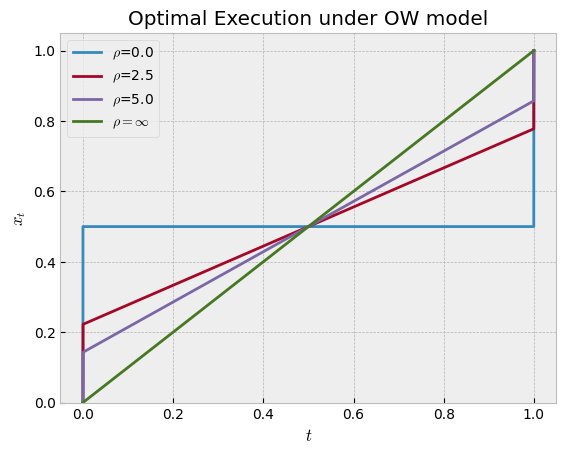

In [3]:
X_0 = 1
T = 1

n=5000
fig, ax = plt.subplots()

for rho in np.linspace(0, 5, 3):
    
    ow = ObizhaevaWang(X_0=X_0, rho=rho, T=T)
    optimal_trades = ow.optimal_trades(n)

    x = np.concatenate([np.array([0]),np.linspace(0, ow.T, n)])
    optimal_trades = np.concatenate([np.array([0]), optimal_trades])

    ax.plot(x,optimal_trades.cumsum(), label=rf'$ \rho $={ow.rho}')


ow = ObizhaevaWang(X_0=X_0, rho=10000, T=T)
optimal_trades = ow.optimal_trades(n)

x = np.concatenate([np.array([0]),np.linspace(0, ow.T, n)])
optimal_trades = np.concatenate([np.array([0]), optimal_trades])

ax.plot(x,optimal_trades.cumsum(), label=rf'$ \rho = \infty $')

ax.set_ylim(bottom=0)
ax.legend()
ax.set_ylabel(r"$ x_t $")
ax.set_xlabel(r"$ t $")
ax.set_title("Optimal Execution under OW model")

fig.savefig(PLOT_FOLDER/'lit_review'/'ow_optimal_trades.png')


## Intraday Volume Example

In [4]:
da = DA()

last_record = da.get_last_records_10min()

ticker = 'ESZ22'
start_date, end_date = '2022-11-01','2022-11-30'
min_bin = 30

esm22_data = da.sql_get_futures_bars(ticker,da.table_10min,start_date, end_date)

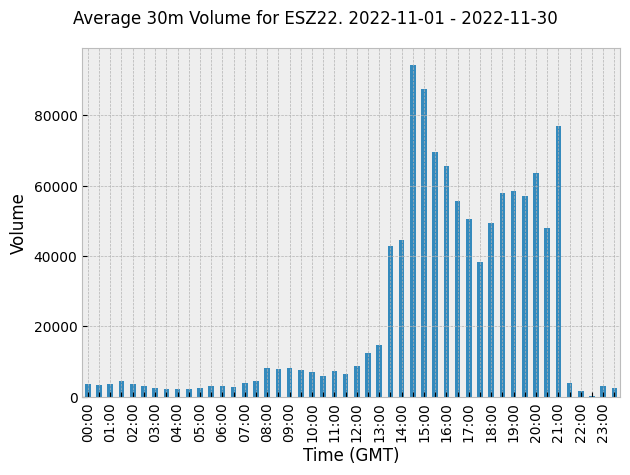

In [6]:
esm22 = esm22_data.copy()
esm22 = esm22.set_index('datetime_utc')[['volume']]
esm22.index = pd.to_datetime(esm22.index)

esm22 = esm22.resample(timedelta(minutes=min_bin)).sum()

esm22['time'] = esm22.index.time
esm22['date'] = esm22.index.date

esm22 = esm22.pivot(columns='date',index='time', values='volume').mean(axis=1).to_frame()

ax = esm22.plot.bar()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [label[:5] if not idx%2 else None for idx, label in enumerate(labels) ]
lables = ax.set_xticklabels(labels)

ax.set_xlabel('Time (GMT)')
ax.set_ylabel('Volume')
ax.get_legend().remove()

fig = ax.get_figure()
fig.suptitle(f'Average {min_bin}m Volume for {ticker}. {start_date} - {end_date}')
fig.tight_layout()
fig.savefig(PLOT_FOLDER/'lit_review'/'average_volume.png')